# Chapter 3. Simple Linear Regression: Rushing Yards Over Expected
Football is a contextual sport. Consider whether a pass is completed. This depends on multiple factors: Was the quarterback under pressure (making it harder to complete)? Was the defense expecting a pass (which would make it harder to complete)? What was the depth of the pass (completion percentage goes down with the depth of the target)?

What turns people off to football analytics are conclusions that they feel lack a contextual understanding of the game. “Raw numbers” can be misleading. Sam Bradford once set the NFL record for completion percentage in a season as a member of the Minnesota Vikings in 2016.

Luckily, given the great work of the people supporting nflfastR, you can provide your own context for metrics by applying the statistical tool known as regression. Through regression, you can normalize, or control for, variables (or features) that have been shown to affect a player’s production. Whether a feature predicts a player’s production is incredibly hard to prove in real life.

The process of normalization in both the public and private football analytics space generally requires models that are more involved than a simple linear regression, the model covered in this chapter. But we have to start somewhere. And simple linear regression provides a nice start to modeling because it is both understandable and the foundation for many other types of analyses.

Note

Many fields use simple linear regression, which leads to the use of multiple terms. Mathematically, the predictor variable is usually x, and the response variable is usually y. Some synonyms for x include predictor variable, feature, explanatory variable, and independent variable. Some synonyms for y include response variable, target, and dependent variable. Likewise, medical studies often correct for exogenous or confounding data (variables to statisticians or features to data scientists) such as education level, age, or other socioeconomic data. You are learning the same concepts in this chapter and Chapter 4 with the terms normalize and control for.

Simple linear regression consists of a model with a single explanatory variable that is assumed to be linearly related to a single dependent variable, or feature. A simple linear regression fits the statistically “best” straight line by using one independent predictor variable to estimate a response variable as a function of the predictor. Simple refers to having only one predictor variable as well an intercept, an assumption Chapter 4 shows you how to relax. Linear refers to the straight line (compared to a curved line or polynomial line for those of you who remember high school algebra).

Regression originally referred to the idea that observations will return, or regress, to the average over time, as noted by Francis Galton in 1877. For example, if a running back has above-average rushing yards per carry one year, we would statistically expect them to revert, or regress, to the league average in future years, all else being equal. The linear assumption made in many models is often onerous but is generally fine as a first pass.

To start applying simple linear regression, you are going to work on a problem that has been solved already in the public space, during the 2020 Big Data Bowl. Participants in this event used tracking data (the positioning, direction, and orientation of all 22 on-field players every tenth of a second) to model the expected rushing yards gained on a play. This value was then subtracted from a player’s actual rushing yards on a play to determine their rushing yards over expected (RYOE). As we talked about in Chapter 1, this kind of residual analysis is a cornerstone exercise in all of sports analytics. Regardless of the mechanics of the model, the broad idea is to adjust for the situation a rusher has to undergo to gain yards.

To mimic RYOE, but on a much smaller scale, you will use the yards to go on a given play. Recall that each football play has a down and distance, where down refers to the place in the four-down sequence a team is in to either pick up 10 yards or score either a touchdown or field goal. Distance, or yards to go, refers to the distance left to achieve that goal and is coded in the data as ydstogo.

A reasonable person would expect that the specific down and yards to go affect RYOE. This observation occurs because it is easier to run the ball when more yards to go exist because the defense will usually try to prevent longer plays. For example, when an offense faces third down and 10 yards to go, the defense is playing back in hopes of avoiding a big play. Conversely, while on second down and 1 yard to go, the defense is playing up to try to prevent a first down or touchdown. Metrics like RYOE help normalize the context of a running back’s plays.

Many example players exist from the history of the NFL. Mike Alstott, the Tampa Bay Buccaneers second-round pick in 1996, often served as the short-yardage back on the upstart Bucs teams of the late-1990s/early-2000s. In contrast, his backfield mate, Warrick Dunn, the team’s first-round choice in 1997, served in the “early-down” role. As a result, their yards-per-carry numbers were different as members of the same team: 3.7 yards for Alstott and 4.0 yards for Dunn. Thus, regression can help you account for that and make better comparisons to create metrics such as RYOE.

Understanding simple linear regression from this chapter also serves as a foundation for skills covered in other chapters, such as more complex RYOE models in Chapter 4, completion percentage over expected in the passing game in Chapter 5, touchdown passes per game in Chapter 6, and models used to evaluate draft data in Chapter 7. Many people, including the authors, call linear models both the workhorse and foundation for applied statistics and data science.


In [3]:
import pandas as pd
import numpy as np
np.float_ = np.float64
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [5]:
pbp_py_run =\
    pbp_py.query('play_type == "run" & rusher_id.notnull()')\
    .reset_index()
# replace null rushing yards with 0
pbp_py_run\
    .loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

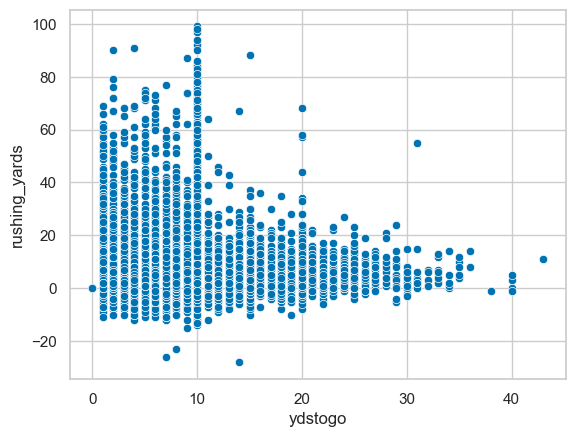

In [6]:
# take a look at the raw data first
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

It’s hard to see whether a relation exists between the yards to go and the number of rushing yards gained on a play. You can do some things to make the plot easier to read. First, add a trend line to see if the data slopes upward, downward, or neither up nor down.

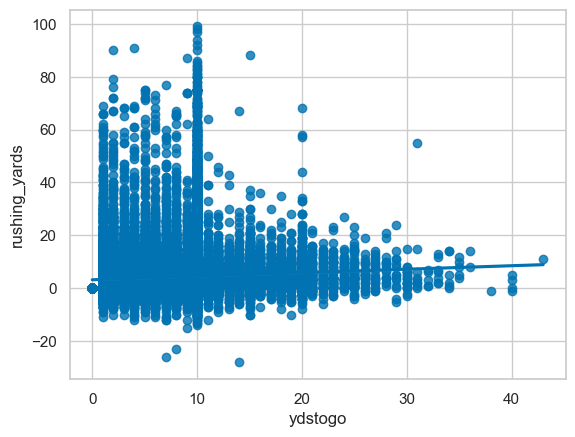

In [7]:
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

You see a positive slope, albeit a very small one. This shows you that rushing gains increase slightly as yards to go increases. Another approach to try to examine the data is binning and averaging. This borrows from the ideas of a histogram, but rather than using the count for each bin, an average is used for each bin. In this case, the bins are easy to define: they are the ydstogo values, which are integers.

Now, average over each yards-per-carry value gained in each bin. In Python, aggregate the data and then plot it

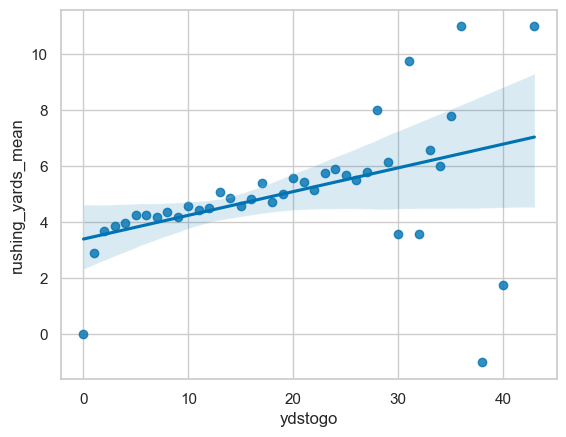

In [9]:
pbp_py_run_avg =\
    pbp_py_run.groupby(["ydstogo"])\
    .agg({"rushing_yards": ["mean"]})

pbp_py_run_avg.columns =\
    list(map("_".join, pbp_py_run_avg.columns))
pbp_py_run_avg.reset_index(inplace=True)

sns.regplot(data = pbp_py_run_avg, x = "ydstogo", y = "rushing_yards_mean");
plt.show();
# the average rushing yards gained for every ydstogo distance

You again see a positive linear relationship between average yards gained and yards to go. While binning and averaging is not a substitute for regressing along the entire dataset, the approach can give you insight into whether such an endeavor is worth doing in the first place and helps you to better “see” the data.



## Simple Linear Regression
Now that you’ve wrangled and interrogated the data, you’re ready to run a simple linear regression. Python and R use the same formula notation for the functions we show you in this book. For example, to build a simple linear regression where ydstogo predicts rushing_yards, you use the formula 

rushing_yards ~ 1 + ydstogo.

The left hand side of the formula contains the target, or response, variable. The right hand side of the formula contains the response, or predictor, variables. Chapter 4 shows how to use multiple predictors that are separated by a +.

You can read this formula as rushing_yards are *predicted by* (indicated by the tilde) an intercept (1) and a slope parameter for yards to go (ydstogo). The 1 is an optional value to explicitly tell you where the model contains an intercept. Most people do not usually include an intercept in the formula, but we include it here to help you explicitly think about this term in the model.

We are using the statsmodels package because it is better for statistical inference compared to the more popular Python package scikit-learn that is better for machine learning. Additionally, statsmodels uses similar syntax as R, which allows you to more readily compare the two languages.

In Python, use the statsmodels package’s formula.api imported as smf, to run an ordinary least-squares regression, ols(). To build the model, you will need to tell Python how to fit the regression, which is where the formula, rushing_yards ~ 1 + ydstogo, comes into play.

Using Python, build the model, fit the model, and then look at the model’s summary:

In [10]:
yard_to_go_py = \
    smf.ols(formula = 'rushing_yards ~ 1 + ydstogo', data = pbp_py_run)
print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     623.7
Date:                Fri, 20 Sep 2024   Prob (F-statistic):          3.28e-137
Time:                        12:13:56   Log-Likelihood:            -3.0102e+05
No. Observations:               92410   AIC:                         6.021e+05
Df Residuals:                   92408   BIC:                         6.021e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2182      0.047     68.125      0.0